In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"veerendranadhvallepu","key":"7be99ca45c83823cfa1ee3bdc1aa6a7c"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Set permissions for the kaggle.json file (read/write for owner only)
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download masoudnickparvar/brain-tumor-mri-dataset

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
 98% 145M/149M [00:04<00:00, 43.7MB/s]
100% 149M/149M [00:04<00:00, 36.5MB/s]


In [5]:
!unzip /content/brain-tumor-mri-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Training/glioma/Tr-gl_0712.jpg  
  inflating: Training/glioma/Tr-gl_0713.jpg  
  inflating: Training/glioma/Tr-gl_0714.jpg  
  inflating: Training/glioma/Tr-gl_0715.jpg  
  inflating: Training/glioma/Tr-gl_0716.jpg  
  inflating: Training/glioma/Tr-gl_0717.jpg  
  inflating: Training/glioma/Tr-gl_0718.jpg  
  inflating: Training/glioma/Tr-gl_0719.jpg  
  inflating: Training/glioma/Tr-gl_0720.jpg  
  inflating: Training/glioma/Tr-gl_0721.jpg  
  inflating: Training/glioma/Tr-gl_0722.jpg  
  inflating: Training/glioma/Tr-gl_0723.jpg  
  inflating: Training/glioma/Tr-gl_0724.jpg  
  inflating: Training/glioma/Tr-gl_0725.jpg  
  inflating: Training/glioma/Tr-gl_0726.jpg  
  inflating: Training/glioma/Tr-gl_0727.jpg  
  inflating: Training/glioma/Tr-gl_0728.jpg  
  inflating: Training/glioma/Tr-gl_0729.jpg  
  inflating: Training/glioma/Tr-gl_0730.jpg  
  inflating: Training/glioma/Tr-gl_0731.jpg  
  inflating: Training/glioma/

In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from PIL import Image
from tqdm import tqdm


# Data Preparation

In [7]:
class BrainMRIDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        self.images = self._load_images()

    def _load_images(self):
        images = []
        for class_name in self.classes:
            class_path = os.path.join(self.root_dir, class_name)
            for img_name in os.listdir(class_path):
                if img_name.endswith('.jpg'):
                    img_path = os.path.join(class_path, img_name)
                    images.append((img_path, self.class_to_idx[class_name]))
        return images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path, label = self.images[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

# Define transforms

In [8]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# Set data paths

In [9]:
data_dir = '/content/'
train_dir = os.path.join(data_dir, 'Training')
test_dir = os.path.join(data_dir, 'Testing')

# Create datasets

In [10]:
train_dataset = BrainMRIDataset(train_dir, transform=data_transforms['train'])
test_dataset = BrainMRIDataset(test_dir, transform=data_transforms['test'])

# Create dataloaders

In [11]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model Setup

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 4)  # 4 output classes
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 201MB/s]


In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

# Training Function

In [14]:
train_loss=[]
train_accuracy=[]
test_loss=[]
test_accuracy=[]

In [15]:
def train_model(model, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_dataset)
        epoch_acc = correct / total*100
        train_loss.append(epoch_loss)
        train_accuracy.append(epoch_acc)

        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in tqdm(test_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                # Calculate accuracy
        epoch_loss1 = running_loss / len(test_dataset)
        epoch_acc1 = correct / total*100
        test_loss.append(epoch_loss)
        test_accuracy.append(epoch_acc)

        print(f'Train Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}, Test Loss: {epoch_loss1:.4f}, Test Acc: {epoch_acc1:.4f}')

    print('Training completed!')

    return model

# Train the model

In [16]:
model = train_model(model, criterion, optimizer, num_epochs=10)

Epoch 1/10: 100%|██████████| 41/41 [00:06<00:00,  5.92it/s]


Train Loss: 0.3521, Acc: 87.3074, Test Loss: 0.7166, Test Acc: 80.5492


Epoch 2/10: 100%|██████████| 41/41 [00:06<00:00,  6.68it/s]


Train Loss: 0.1936, Acc: 92.7521, Test Loss: 0.4587, Test Acc: 83.5240


Epoch 3/10: 100%|██████████| 41/41 [00:07<00:00,  5.71it/s]


Train Loss: 0.1580, Acc: 94.4153, Test Loss: 0.4725, Test Acc: 83.8291


Epoch 4/10: 100%|██████████| 41/41 [00:06<00:00,  5.92it/s]


Train Loss: 0.1070, Acc: 96.0959, Test Loss: 0.2167, Test Acc: 90.6941


Epoch 5/10: 100%|██████████| 41/41 [00:06<00:00,  6.76it/s]


Train Loss: 0.0981, Acc: 96.7437, Test Loss: 0.0834, Test Acc: 97.2540


Epoch 6/10: 100%|██████████| 41/41 [00:07<00:00,  5.74it/s]


Train Loss: 0.0850, Acc: 97.1113, Test Loss: 0.1452, Test Acc: 95.4996


Epoch 7/10: 100%|██████████| 41/41 [00:06<00:00,  5.90it/s]


Train Loss: 0.0761, Acc: 97.3039, Test Loss: 0.1646, Test Acc: 93.5927


Epoch 8/10: 100%|██████████| 41/41 [00:06<00:00,  6.78it/s]


Train Loss: 0.0665, Acc: 97.7066, Test Loss: 0.0409, Test Acc: 98.4744


Epoch 9/10: 100%|██████████| 41/41 [00:07<00:00,  5.66it/s]


Train Loss: 0.0612, Acc: 97.8291, Test Loss: 0.0673, Test Acc: 97.7879


Epoch 10/10: 100%|██████████| 41/41 [00:07<00:00,  5.83it/s]

Train Loss: 0.0545, Acc: 98.1092, Test Loss: 0.1049, Test Acc: 96.9489
Training completed!


# Save model

In [17]:
torch.save(model.state_dict(), '/content/drive/MyDrive/Brain/brain_tumor_resnet18.pth')

In [18]:
import matplotlib.pyplot as plt
import matplotlib

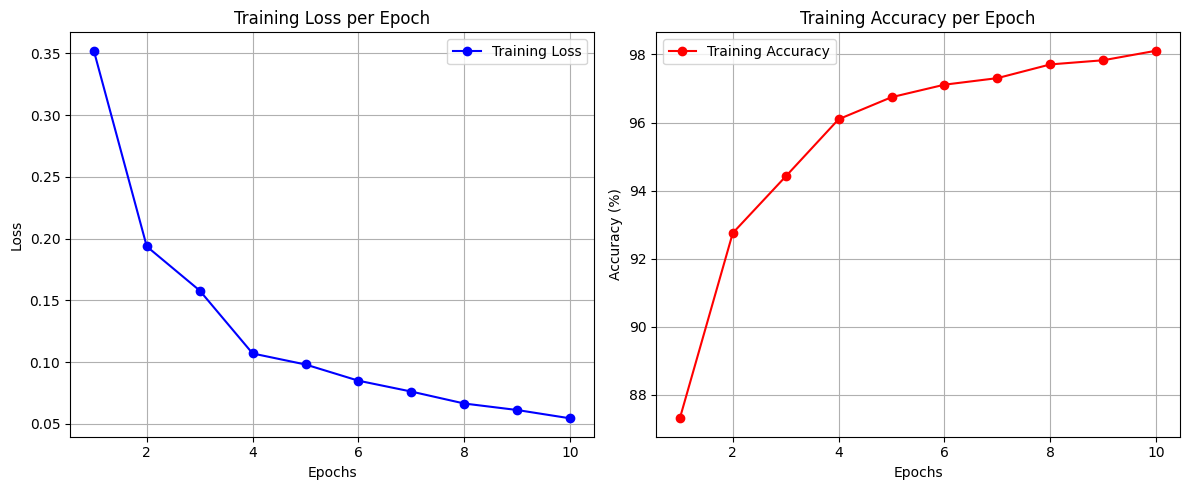

In [24]:
epochs = range(1, len(train_loss) + 1)
plt.figure(figsize=(12, 5))

# Plotting Training and Test Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.title('Training Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plotting Training and Test Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'ro-', label='Training Accuracy')
plt.title('Training Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

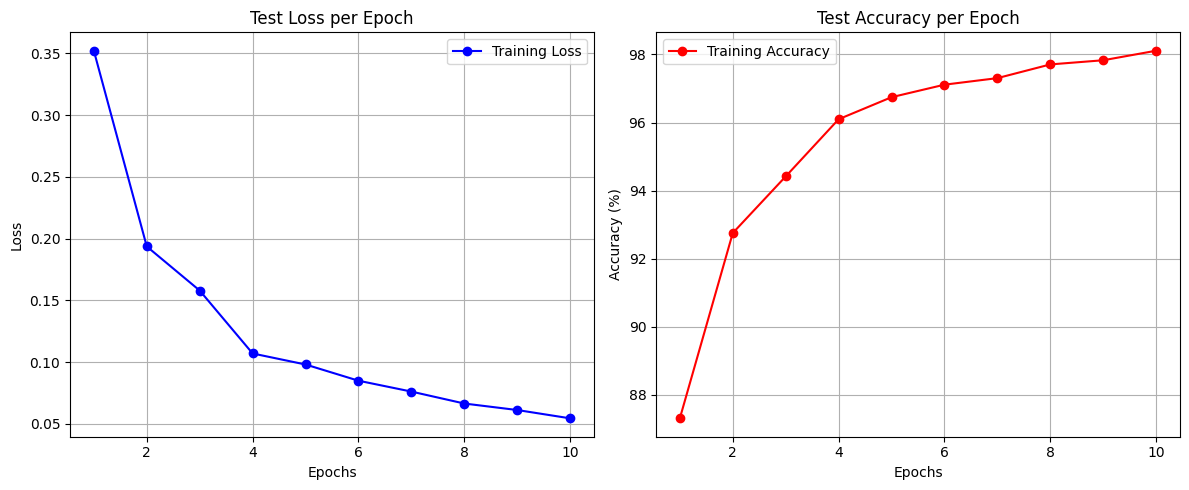

In [25]:
epochs = range(1, len(train_loss) + 1)
plt.figure(figsize=(12, 5))

# Plotting Training and Test Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, test_loss, 'bo-', label='Training Loss')
plt.title('Test Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plotting Training and Test Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, test_accuracy, 'ro-', label='Training Accuracy')
plt.title('Test Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Evaluation


In [20]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Test Accuracy: {correct / total*100:.4f}')

Test Accuracy: 96.9489


Evaluating: 100%|██████████| 41/41 [00:07<00:00,  5.52it/s]


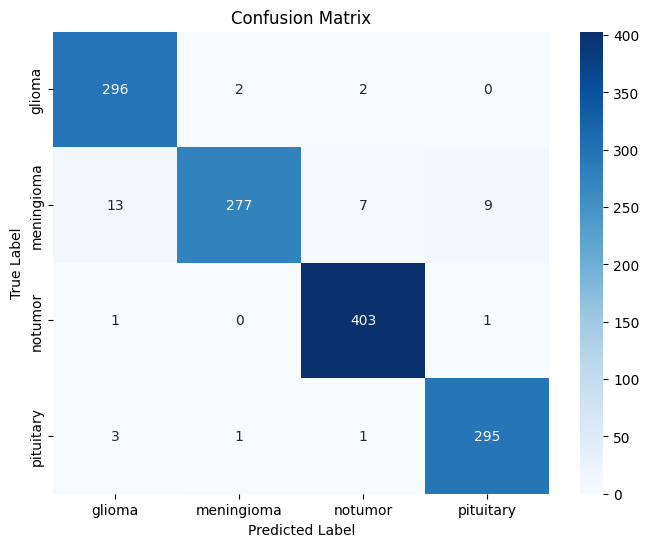

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

model.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
  for inputs, labels in tqdm(test_loader, desc='Evaluating'):
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    _, predicted = torch.max(outputs, 1)

    all_labels.extend(labels.cpu().numpy())
    all_predictions.extend(predicted.cpu().numpy())

cm = confusion_matrix(all_labels, all_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()